<a href="https://colab.research.google.com/github/harry418/Trafficy/blob/main/Accident%20Detection/Post_crash_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset
Dataset is taken from making_dataset.ipynb. since lack of memory and ram we are only using 10% of dataset available at [link text](https://drive.google.com/open?id=1o0D7vnGUZHS72is6n1jV1ge2BDfObzVi)

https://drive.google.com/open?id=1o0D7vnGUZHS72is6n1jV1ge2BDfObzVi

**Importing Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Use the application default credentials
cred = credentials.Certificate('/content/try.json')
firebase_admin.initialize_app(cred)
db = firestore.client()

**Unzipping 10 percent of dataset.**

In [ ]:
!unzip '/content/drive/MyDrive/crash_detection/dataset_10_percent.zip' 

Archive:  /content/drive/MyDrive/crash_detection/dataset_10_percent.zip
   creating: content/crashs/train/
   creating: content/crashs/train/noaccident/
  inflating: content/crashs/train/noaccident/00001581.jpg  
  inflating: content/crashs/train/noaccident/00003882.jpg  
  inflating: content/crashs/train/noaccident/e1 0626.jpg  
  inflating: content/crashs/train/noaccident/d2 0007.jpg  
  inflating: content/crashs/train/noaccident/00001433.jpg  
  inflating: content/crashs/train/noaccident/d1 0517.jpg  
  inflating: content/crashs/train/noaccident/00000421.jpg  
  inflating: content/crashs/train/noaccident/b3 0096.jpg  
  inflating: content/crashs/train/noaccident/c2 1127.jpg  
  inflating: content/crashs/train/noaccident/a2 2395.jpg  
  inflating: content/crashs/train/noaccident/e2 0832.jpg  
  inflating: content/crashs/train/noaccident/d2 0232.jpg  
  inflating: content/crashs/train/noaccident/a2 3504.jpg  
  inflating: content/crashs/train/noaccident/b3 0421.jpg  
  inflating: cont

**Check files in directory.**

In [ ]:
import os

  # dir is your directory path
num_files = os.listdir('content/crashs/train')
print(num_files)

['accident', 'noaccident']


In [ ]:
import os
for i in num_files:
  path, dirs, files = next(os.walk('content/crashs/train'+'/'+i))
  file_count = len(files)
  print('{} contain {} number of files.'.format(i,str(file_count)))

accident contain 1333 number of files.
noaccident contain 2566 number of files.


**Setting Directory as current workspace.**

In [ ]:
data_train = 'content/crashs/train'

# Classification

**Install and upgrade FastAI.**

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 5.8MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 244kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


**Import Required libraries from fastai.**

In [ ]:
from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import *

#from fastai.vision.core import *
from fastai.vision.data import *

**Making a Datablock for preprocessing and classification.**

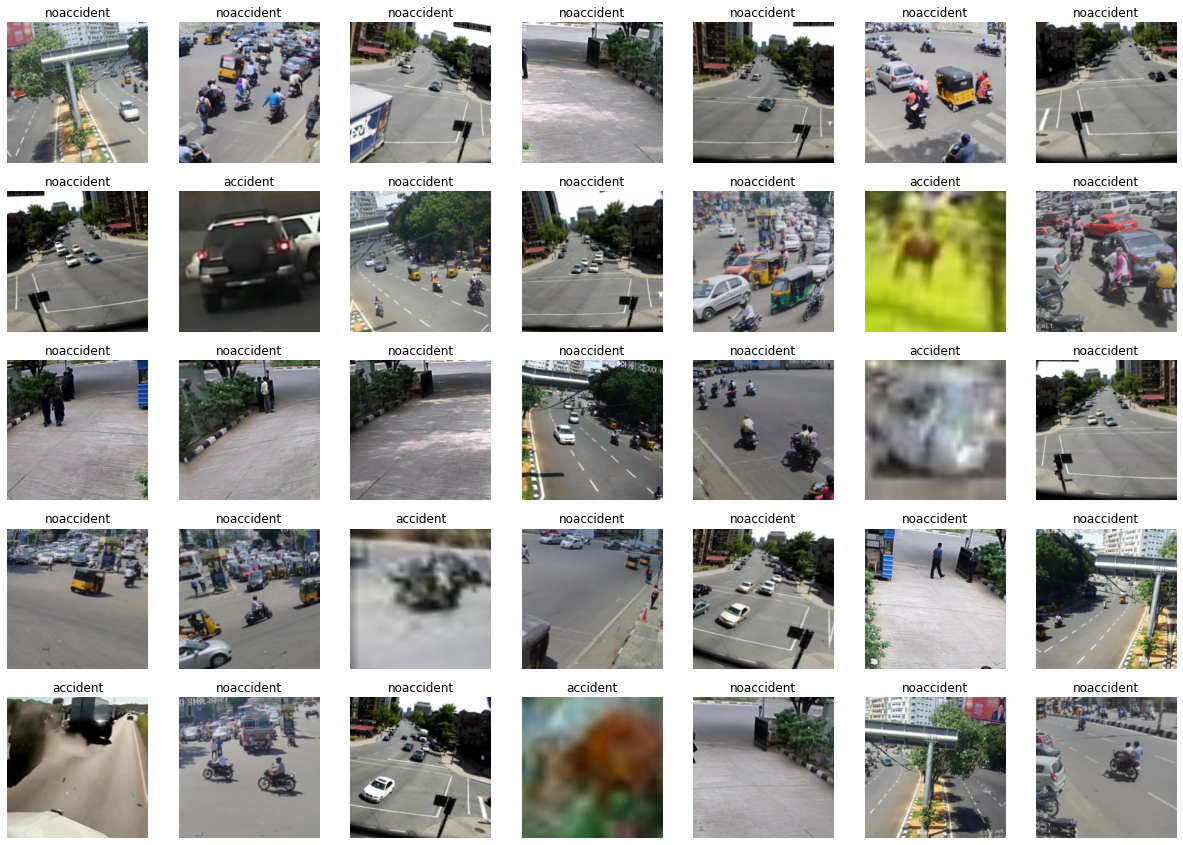

In [ ]:

dblock = DataBlock(blocks= (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = parent_label,
                   splitter  = RandomSplitter(),
                   batch_tfms=aug_transforms(),
                   item_tfms = Resize(224,224))
dls = dblock.dataloaders(data_train)
dls.show_batch(max_n=35)

# Resnet50 Training

**Create a cnn_learner using Resnet50 as architecture and set accuracy and error rate as validation matrix. tune model upto 5 epochs.**

In [ ]:
learner1 = cnn_learner(dls,models.resnet50,metrics=[accuracy,error_rate])
learner1.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.238511,0.126303,0.980745,0.019255,01:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.100497,0.107841,0.983312,0.016688,01:14
1,0.093964,0.099879,0.987163,0.012837,01:14
2,0.058771,0.071323,0.987163,0.012837,01:13
3,0.034847,0.088981,0.988447,0.011553,01:13
4,0.020561,0.087773,0.988447,0.011553,01:15


**Unfreeze weights of last layers, and train on optimum cyclic learning rate. and use savedModelCallback for saving Best model weights.**

# Results

**Plotting validation loss during training.**

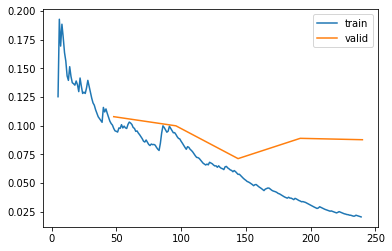

In [ ]:
learner1.recorder.plot_loss()

**Confusion matrics**

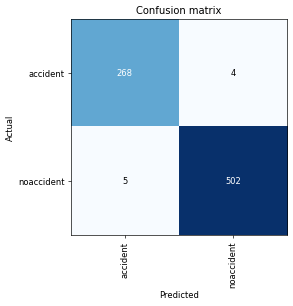

In [ ]:
interp = ClassificationInterpretation.from_learner(learner1)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

**Classification Report**

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

    accident       0.98      0.99      0.98       272
  noaccident       0.99      0.99      0.99       507

    accuracy                           0.99       779
   macro avg       0.99      0.99      0.99       779
weighted avg       0.99      0.99      0.99       779



**Show results**

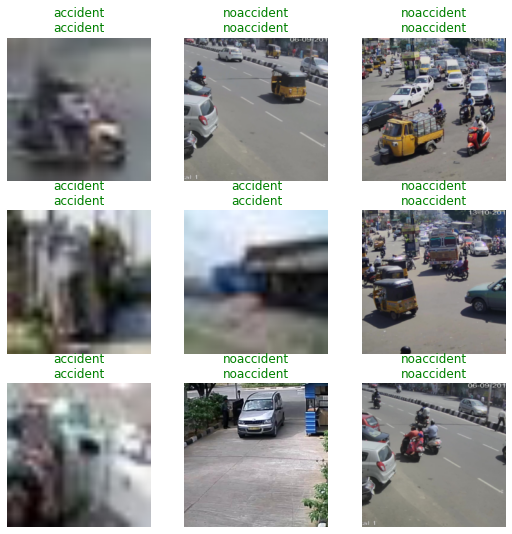

In [ ]:
learner1.show_results()

In [ ]:
#exporting the weight file
learner1.export()


#Importing the weight file and Testing

In [ ]:
learn = load_learner('/content/drive/MyDrive/crash_detection/res50.pkl')

In [ ]:
pred1
#pred = learn.predict("/content/car.webp")

('noaccident', tensor(1), tensor([0.0691, 0.9309]))

In [ ]:
pred1[2][]

'noaccident'

In [ ]:
pred = learn.predict('/content/car2.jpg')

In [ ]:
str(pred[2][0]).replace('tensor','')

'(0.9947)'

In [ ]:
import datetime

In [ ]:
if pred[0] == 'accident':
  db.collection(u'crashes').add({"cam_no. ": 1,
                               "Date ": datetime.datetime.now(),
                               "Place": "Delhi",
                               "Confidence":str(pred[2][0]).replace('tensor','')})